# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, LeaveOneOut, GridSearchCV
from sklearn.svm import SVC

# Loading Data

In [3]:
auto = pd.read_csv("../data/Auto.csv", na_values="?", index_col="name")
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130.0,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165.0,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150.0,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150.0,3433,12.0,70,1
ford torino,17.0,8,302.0,140.0,3449,10.5,70,1


# Cleaning Data

In [4]:
auto = auto.dropna()
auto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, chevrolet chevelle malibu to chevy s-10
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 27.6+ KB


# Data Exploration

In [5]:
# Create conditional variable checking whether mpg > median
mpg_median = auto["mpg"].median()
auto["mpg01"] = [1 if mpg > mpg_median else 0 for mpg in auto["mpg"]]
auto["mpg01"].value_counts()

0    196
1    196
Name: mpg01, dtype: int64

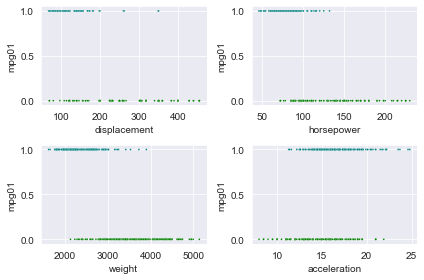

In [6]:
# Scatter-plots with quantitative predictors
colors = ["teal" if indicator else "green" for indicator in auto["mpg01"]]

fig, ax = plt.subplots(2, 2)
for i, col in enumerate(auto.columns[2:6]):
    if i < 2:
        sns.scatterplot(x=auto[col], y=auto["mpg01"], ax=ax[0, i], s=3, c=colors)
    else:
        sns.scatterplot(x=auto[col], y=auto["mpg01"], ax=ax[1, i-2], s=3, c=colors)

fig.tight_layout()
plt.show()

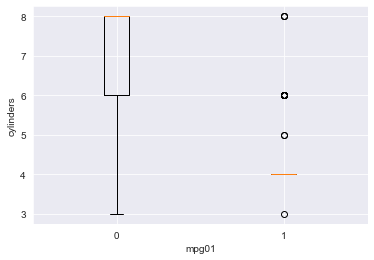

In [7]:
# Box-plot of mpg01 against cylinders
data = [auto.loc[auto.mpg01 == 0, "cylinders"], auto.loc[auto.mpg01 == 1, "cylinders"]]

fig, ax = plt.subplots()
ax.boxplot(data)

ax.set_xticklabels([0, 1])
ax.set_xlabel("mpg01")
ax.set_ylabel("cylinders")

plt.show()

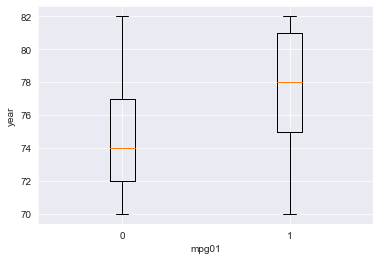

In [8]:
# Box-plot of mpg01 against year
data = [auto.loc[auto.mpg01 == 0, "year"], auto.loc[auto.mpg01 == 1, "year"]]

_, ax = plt.subplots()
ax.boxplot(data)

ax.set_xticklabels([0, 1])
ax.set_xlabel("mpg01")
ax.set_ylabel("year")

plt.show()

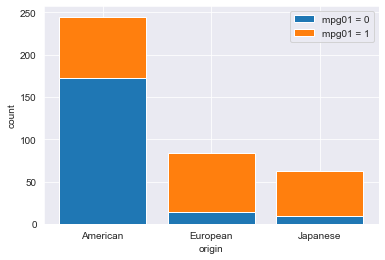

In [9]:
# Box-plot of mpg01 against origin
lower_mpg = auto.loc[auto.mpg01 == 0, "origin"].value_counts()
higher_mpg = auto.loc[auto.mpg01 == 1, "origin"].value_counts()

_, ax = plt.subplots()
ax.bar(range(1, 4), lower_mpg, label='mpg01 = 0')
ax.bar(range(1, 4), higher_mpg, bottom=lower_mpg, label='mpg01 = 1')

ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["American", "European", "Japanese"])
ax.set_xlabel("origin")
ax.set_ylabel("count")
ax.legend()

plt.show()

# Data Analysis

In [10]:
# Test for collinearity
auto[["displacement", "horsepower", "weight", "cylinders", "acceleration", "origin", "year", "mpg01"]].corr()

,displacement,horsepower,weight,cylinders,acceleration,origin,year,mpg01
displacement,1.000000,0.897257,0.932994,0.950823,-0.543800,-0.614535,-0.369855,-0.753477
horsepower,0.897257,1.000000,0.864538,0.842983,-0.689196,-0.455171,-0.416361,-0.667053
weight,0.932994,0.864538,1.000000,0.897527,-0.416839,-0.585005,-0.309120,-0.757757
cylinders,0.950823,0.842983,0.897527,1.000000,-0.504683,-0.568932,-0.345647,-0.759194
acceleration,-0.543800,-0.689196,-0.416839,-0.504683,1.000000,0.212746,0.290316,0.346822
origin,-0.614535,-0.455171,-0.585005,-0.568932,0.212746,1.000000,0.181528,0.513698
year,-0.369855,-0.416361,-0.309120,-0.345647,0.290316,0.181528,1.000000,0.429904
mpg01,-0.753477,-0.667053,-0.757757,-0.759194,0.346822,0.513698,0.429904,1.000000


In [11]:
# Feature selection
X = auto[["horsepower", "year", "origin", "acceleration"]]
y = auto["mpg01"]

In [12]:
# One-Hot Encoding
enc = make_column_transformer((OneHotEncoder(), ["origin"]), remainder="passthrough")
X = pd.DataFrame(enc.fit_transform(X), columns=enc.get_feature_names_out())\
              .iloc[:, 1:]

In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [14]:
# Linear discriminant analysis (LDA) classifier
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
lda.score(X_test, y_test)

0.9081632653061225

In [15]:
# Quadratic discriminant analysis (QDA) classifier
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
qda.score(X_test, y_test)

0.8877551020408163

In [16]:
# Logistic regression classifier
log_reg = LogisticRegression(solver="newton-cg")
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

0.9285714285714286

In [17]:
# Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb.score(X_test, y_test)

0.8775510204081632

In [18]:
# 1-Nearest-Neighbor (KNN, K=1) Classifier
one_nearest = KNeighborsClassifier(n_neighbors=1)
one_nearest.fit(X_train, y_train)
one_nearest.score(X_test, y_test)

0.8673469387755102

In [19]:
# 2-Nearest-Neighbor (KNN, K=2) Classifier
two_nearest = KNeighborsClassifier(n_neighbors=2)
two_nearest.fit(X_train, y_train)
two_nearest.score(X_test, y_test)

0.8775510204081632

In [20]:
# 4-Nearest-Neighbor (KNN, K=4) Classifier
four_nearest = KNeighborsClassifier(n_neighbors=4)
four_nearest.fit(X_train, y_train)
four_nearest.score(X_test, y_test)

0.9183673469387755

In [21]:
# 8-Nearest-Neighbor (KNN, K=8) Classifier
eight_nearest = KNeighborsClassifier(n_neighbors=8)
eight_nearest.fit(X_train, y_train)
eight_nearest.score(X_test, y_test)

0.8979591836734694

# Cross Validation

In [22]:
# k-Fold Cross Validation (k=5): Logistic Regression
np.mean(cross_val_score(log_reg, X, y, cv=5))

0.8394352482960077

In [23]:
# Leave-One-Out Cross Validation (LOOCV): Logistic Regression
loocv = LeaveOneOut()
np.mean(cross_val_score(log_reg, X, y, cv=loocv))

0.8877551020408163

# Support Vector Machines (SVMs)

In [31]:
# Linear kernel SVC
svc = SVC(random_state=0)
svc.fit(X_train, y_train)

[svc.score(X_train, y_train), svc.score(X_test, y_test)]

[0.8435374149659864, 0.8775510204081632]

In [29]:
# Quadratic kernel SVC
tuned_svc = SVC(random_state=0, kernel="poly", degree=2)
tuned_svc.fit(X_train, y_train)

[tuned_svc.score(X_train, y_train), tuned_svc.score(X_test, y_test)]

[0.8333333333333334, 0.8673469387755102]

In [32]:
# Radial basis function kernel SVC
tuned_svc = SVC(random_state=0, kernel="rbf")
tuned_svc.fit(X_train, y_train)

[tuned_svc.score(X_train, y_train), tuned_svc.score(X_test, y_test)]

[0.8435374149659864, 0.8775510204081632]